# Markowitz Python

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [2]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2023, 12, 31)

In [35]:
lista_acoes = ["BBAS3", "BBDC4", "ABCB4", "CEAB3", "TRPL4", "SIMH3", "SLCE3", "POSI3", "CAMB3", "VAMO3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]
# lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, inicio, final)['Adj Close']
precos

[**********************62%%****                  ]  5 of 8 completed

/usr/local/lib/python3.11/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/usr/local/lib/python3.11/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/usr/local/lib/python3.11/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/usr/local/lib/python3.11/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timede

[*********************100%%**********************]  8 of 8 completed


,ABCB4.SA,BBAS3.SA,BBDC4.SA,CEAB3.SA,POSI3.SA,SIMH3.SA,SLCE3.SA,TRPL4.SA
Date,,,,,,,,
2015-01-02,5.254532,13.299432,8.752048,NaN,1.600210,NaN,1.078212,4.967240
2015-01-05,5.212662,13.023460,8.770100,NaN,1.679038,NaN,1.078212,4.973341
2015-01-06,5.087057,13.205480,9.058603,NaN,1.631741,NaN,1.090897,4.945271
2015-01-07,4.986572,13.786782,9.418602,NaN,1.647507,NaN,1.125780,5.086845
2015-01-08,4.990759,13.833759,9.467111,NaN,1.710569,NaN,1.128951,5.119796
...,...,...,...,...,...,...,...,...
2023-12-21,23.070765,54.290001,16.758947,8.18,6.880000,9.46,18.566536,25.430000
2023-12-22,23.158081,54.439999,16.810934,8.02,6.920000,9.60,18.865675,25.590000
2023-12-26,23.208752,54.939999,16.860876,7.83,7.100000,9.64,18.885618,25.559999


In [36]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() #retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov() 

media_retornos

ABCB4.SA    0.001056
BBAS3.SA    0.000986
BBDC4.SA    0.000258
CEAB3.SA   -0.000622
POSI3.SA    0.000721
SIMH3.SA    0.000502
SLCE3.SA    0.001035
TRPL4.SA    0.000671
dtype: float64

In [37]:
matriz_cov

,ABCB4.SA,BBAS3.SA,BBDC4.SA,CEAB3.SA,POSI3.SA,SIMH3.SA,SLCE3.SA,TRPL4.SA
ABCB4.SA,0.000383,0.000189,0.000201,0.000228,0.000245,0.000235,0.000085,0.000080
BBAS3.SA,0.000189,0.000367,0.000244,0.000213,0.000259,0.000226,0.000051,0.000089
BBDC4.SA,0.000201,0.000244,0.000421,0.000230,0.000250,0.000245,0.000044,0.000087
CEAB3.SA,0.000228,0.000213,0.000230,0.001584,0.000585,0.000570,0.000086,0.000121
POSI3.SA,0.000245,0.000259,0.000250,0.000585,0.001480,0.000515,0.000147,0.000112
SIMH3.SA,0.000235,0.000226,0.000245,0.000570,0.000515,0.000909,0.000127,0.000112
SLCE3.SA,0.000085,0.000051,0.000044,0.000086,0.000147,0.000127,0.000493,0.000046
TRPL4.SA,0.000080,0.000089,0.000087,0.000121,0.000112,0.000112,0.000046,0.000166


In [38]:
numero_carteiras = 500000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos) #só pode ter 100% 
    tabela_pesos[k, :] = pesos
    
    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

In [39]:
vetor_sharpe

array([0.6628849 , 0.43910341, 0.50789951, ..., 0.48268699, 0.31020399,
       0.57425326])

In [40]:
indice_do_sharpe_maximo = vetor_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.26647013, 0.22744835, 0.0011948 , 0.01228453, 0.00816286,
       0.00884748, 0.23795251, 0.23763934])

In [41]:
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

tabela_retornos_esperados_arit

array([0.17428591, 0.13614957, 0.15001865, ..., 0.15637361, 0.11300087,
       0.18863504])

In [42]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), 
                                         tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) 

limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    #vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, 
                      constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

In [43]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.20741473169160402
       x: [ 2.869e-01  2.509e-01  2.212e-17  0.000e+00  0.000e+00
            8.348e-17  2.942e-01  1.680e-01]
     nit: 5
     jac: [ 2.378e-01  2.140e-01  1.779e-01  1.999e-01  2.397e-01
            2.190e-01  2.308e-01  1.048e-01]
    nfev: 45
    njev: 5

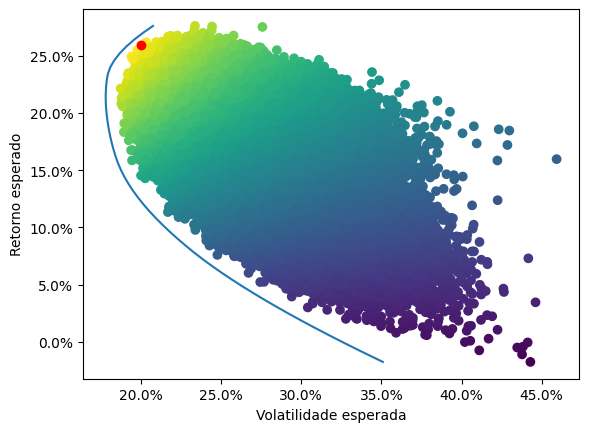

In [44]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[indice_do_sharpe_maximo], 
            tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()